✅ Loaded dataset
Shape: (9471, 17)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN



Missing values per column:
Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64


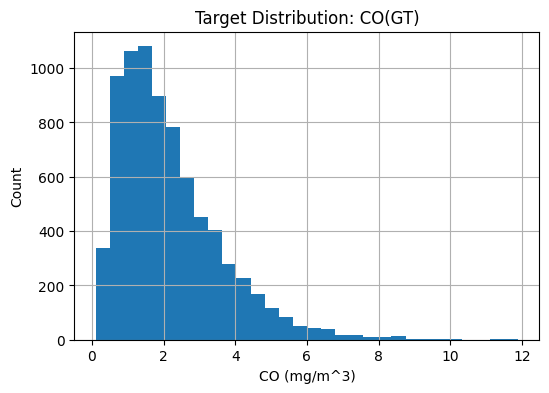

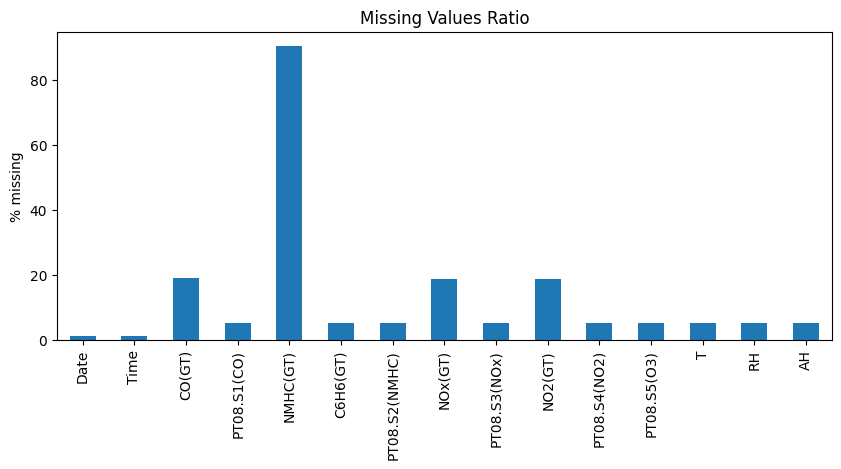

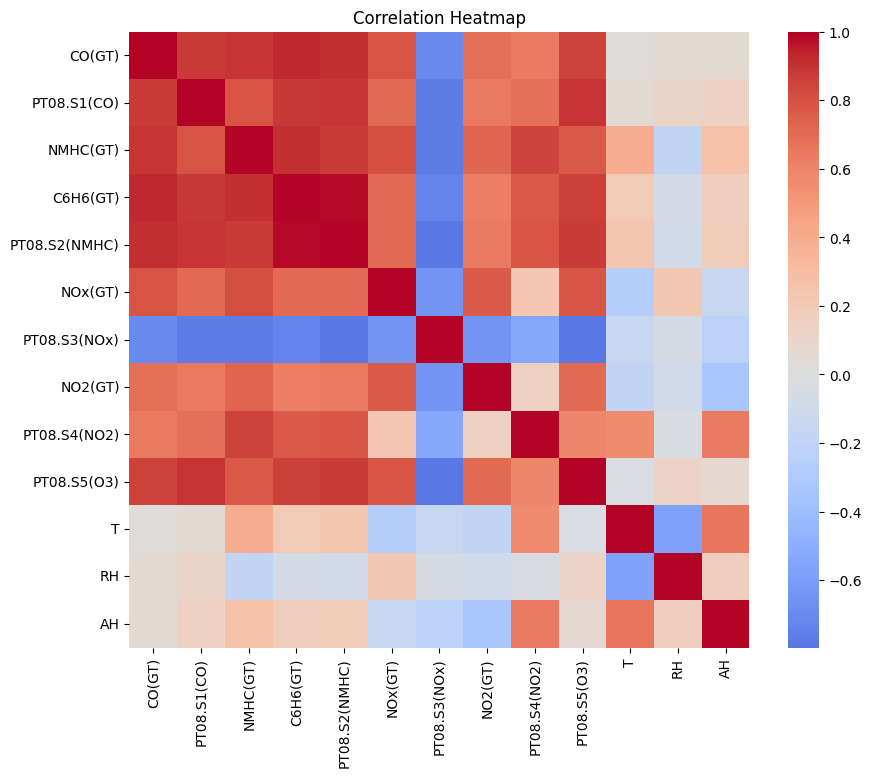

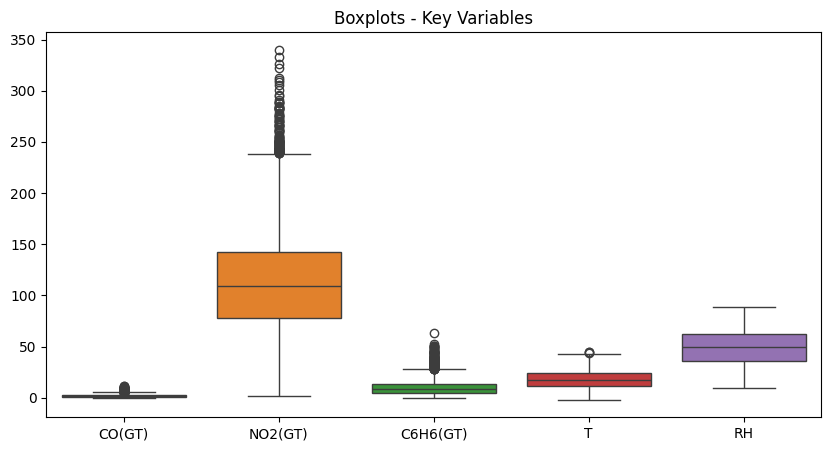

After drop NaN target: (7674, 14) (7674,)
LinearRegression | CV RMSE: 0.510 ± 0.009
Ridge           | CV RMSE: 0.510 ± 0.009
Lasso           | CV RMSE: 0.510 ± 0.009
SVR (RBF)       | CV RMSE: 0.446 ± 0.023
RandomForest    | CV RMSE: 0.443 ± 0.011
kNN             | CV RMSE: 0.443 ± 0.018

=== LinearRegression ===
MSE : 0.251
RMSE: 0.501
MAE : 0.330
R²  : 0.880


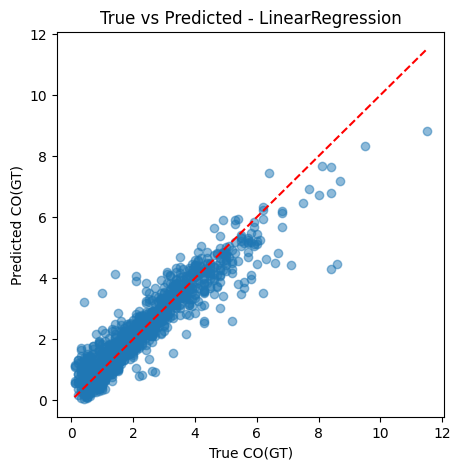


=== Ridge ===
MSE : 0.251
RMSE: 0.501
MAE : 0.330
R²  : 0.880


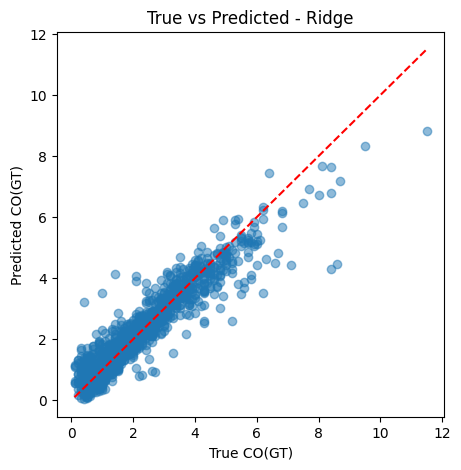


=== Lasso ===
MSE : 0.251
RMSE: 0.501
MAE : 0.330
R²  : 0.880


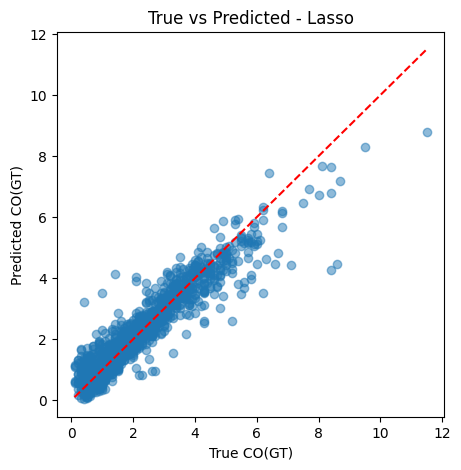


=== SVR (RBF) ===
MSE : 0.185
RMSE: 0.430
MAE : 0.270
R²  : 0.911


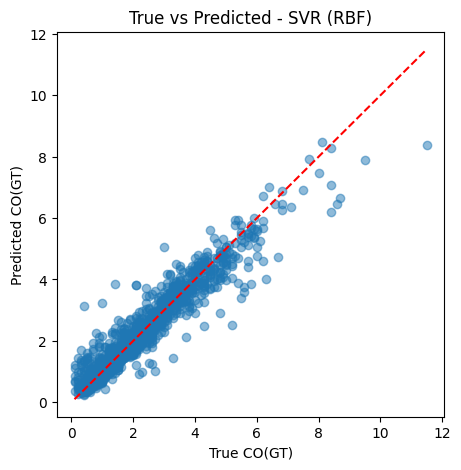


=== RandomForest ===
MSE : 0.185
RMSE: 0.430
MAE : 0.274
R²  : 0.911


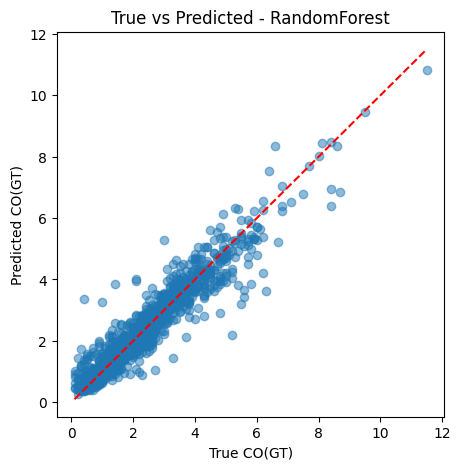


=== kNN ===
MSE : 0.177
RMSE: 0.421
MAE : 0.275
R²  : 0.915


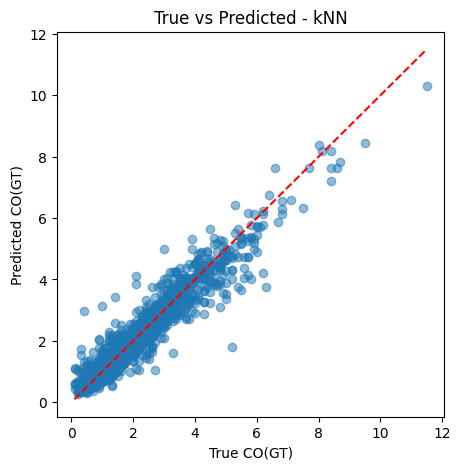

✅ Saved features in 'features/' folder


In [ ]:
# ============================================================
# AIR QUALITY DATASET (UCI) - MACHINE LEARNING PIPELINE
# Task: Regression (predict CO(GT))
# Author: <Your Group Info>
# ============================================================

# ========== 0. SETUP ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import requests

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

os.makedirs("features", exist_ok=True)

# ========== 1. LOAD DATA ==========
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
zip_file_path = "AirQualityUCI.zip"
csv_file_name = "AirQualityUCI.csv"

# Download the zip file
r = requests.get(url, allow_redirects=True)
open(zip_file_path, 'wb').write(r.content)

# Extract the specific CSV file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name)

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file_name, sep=";", decimal=",")

print("✅ Loaded dataset")
print("Shape:", df.shape)
display(df.head())

# ========== 2. EDA ==========
# Drop last empty columns
df = df.iloc[:, :-2]

# Rename cols for easier handling
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Replace missing code -200 with NaN
df = df.replace(-200, np.nan)

print("\nMissing values per column:")
print(df.isnull().sum())

# Target column: CO(GT)
target_col = "CO(GT)"

# Histogram of target
plt.figure(figsize=(6,4))
df[target_col].hist(bins=30)
plt.xlabel("CO (mg/m^3)")
plt.ylabel("Count")
plt.title("Target Distribution: CO(GT)")
plt.show()

# Missing ratio per feature
plt.figure(figsize=(10,4))
(df.isnull().mean()*100).plot(kind="bar")
plt.ylabel("% missing")
plt.title("Missing Values Ratio")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns=["Date", "Time"]).corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# Boxplot for selected pollutants
plt.figure(figsize=(10,5))
sns.boxplot(data=df[["CO(GT)","NO2(GT)","C6H6(GT)","T","RH"]])
plt.title("Boxplots - Key Variables")
plt.show()

# ========== 3. PREPROCESSING ==========
X = df.drop(columns=[target_col])
y = df[target_col]

# Drop rows with NaN in target
mask = y.notna()
X, y = X[mask], y[mask]

print("After drop NaN target:", X.shape, y.shape)

# Identify numeric features excluding 'Date' and 'Time'
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)

pca = PCA(n_components=0.95, random_state=42)

# ========== 4. MODELS ==========
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=5000),
    "SVR (RBF)": SVR(kernel="rbf"),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "kNN": KNeighborsRegressor(n_neighbors=5)
}

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", pca),
        ("model", model)
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
    rmse_scores = np.sqrt(-scores)
    print(f"{name:15s} | CV RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
    results.append([name, rmse_scores.mean(), rmse_scores.std()])

# ========== 5. FINAL EVALUATION ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", pca),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"MSE : {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.3f}")

    # Scatter plot
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
    plt.xlabel("True CO(GT)")
    plt.ylabel("Predicted CO(GT)")
    plt.title(f"True vs Predicted - {name}")
    plt.show()

# ========== 6. SAVE FEATURES ==========
prep_only = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", pca)
])
prep_only.fit(X_train)

X_train_feat = prep_only.transform(X_train)
X_test_feat  = prep_only.transform(X_test)

np.save("features/airq_X_train.npy", X_train_feat)
np.save("features/airq_X_test.npy",  X_test_feat)
np.save("features/airq_y_train.npy", y_train.values)
np.save("features/airq_y_test.npy",  y_test.values)

print("✅ Saved features in 'features/' folder")